**Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')


**Load data**

In [2]:

data = pd.read_csv('creditdata.csv')



**Scale data**

In [3]:
# Select numerical features for scaling (exclude 'Class')
numerical_features = data.drop('Class', axis=1).select_dtypes(include=[np.number]).columns.tolist()

# Initialize RobustScaler
scaler = RobustScaler()

# Scale numerical features
scaled_numerical = scaler.fit_transform(data[numerical_features])
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_features).astype('float32')  # Optimized dtype

# Combine scaled numerical features with 'Class' (ensure no duplication)
scaled_data = pd.concat([scaled_numerical_df, data[['Class']]], axis=1)

# Define X and y
X = scaled_data.drop('Class', axis=1)
y = scaled_data['Class']

# Verify the shapes
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Check for missing or infinite values
if X.isnull().values.any():
    print("X contains missing values. Dropping missing values.")
    X = X.dropna()
    y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Shape of X: (284807, 30)
Shape of y: (284807,)


**Handle imbalances**

In [4]:

smote = SMOTE()
try:
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print(f"Original dataset shape: {y_train.value_counts()}")
    print(f"Resampled dataset shape: {pd.Series(y_resampled).value_counts()}")
except ValueError as e:
    print(f"Error during SMOTE resampling: {e}")
    print(f"Shape of X_train: {X_train.shape}")
    print(f"Shape of y_train: {y_train.shape}")
    print(f"Unique classes in y_train: {y_train.unique()}")
    raise


Original dataset shape: 0    227451
1       394
Name: Class, dtype: int64
Resampled dataset shape: 0    227451
1    227451
Name: Class, dtype: int64


**Train regression**

Logistic Regression AUPRC (Training Set): 0.9917421325015943


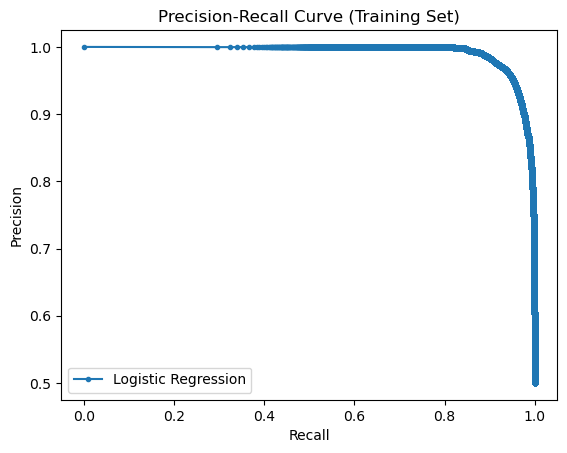

In [5]:

log_reg = LogisticRegression(
    class_weight='balanced',
    solver='saga',
    max_iter=1000,
    random_state=42,
    penalty='l2',
    C=1
)


log_reg.fit(X_resampled, y_resampled)


y_scores = log_reg.predict_proba(X_resampled)[:, 1]
auprc = average_precision_score(y_resampled, y_scores)
print(f"Logistic Regression AUPRC (Training Set): {auprc}")


precision, recall, _ = precision_recall_curve(y_resampled, y_scores)
plt.plot(recall, precision, marker='.', label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Training Set)')
plt.legend()
plt.show()


**Optimize parameters for regression**

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best Logistic Regression AUPRC (Training Set): 0.9917421325015943


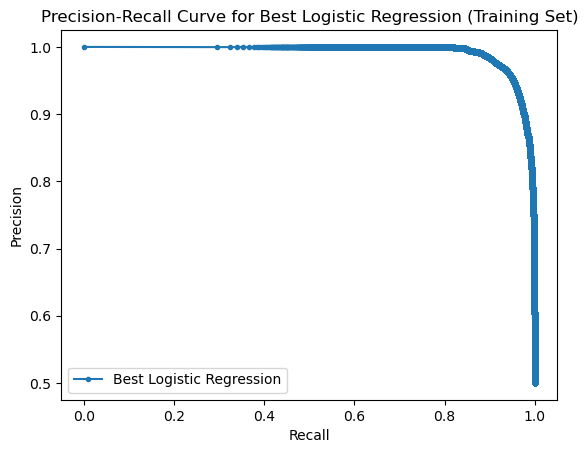

In [6]:
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['saga'],
    'penalty': ['l2']
}

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=3,
    scoring='average_precision',
    n_jobs=1,
    verbose=1
)

try:
    grid_search.fit(X_resampled, y_resampled)
    print(f"Best Parameters: {grid_search.best_params_}")
    best_log_reg = grid_search.best_estimator_

    y_scores_best = best_log_reg.predict_proba(X_resampled)[:, 1]
    auprc_best = average_precision_score(y_resampled, y_scores_best)
    print(f"Best Logistic Regression AUPRC (Training Set): {auprc_best}")

    precision_best, recall_best, _ = precision_recall_curve(y_resampled, y_scores_best)
    plt.plot(recall_best, precision_best, marker='.', label='Best Logistic Regression')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Best Logistic Regression (Training Set)')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"An error occurred during GridSearchCV: {e}")


**Train, optimize, and evaluate random forest**

In [7]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=3,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

try:
    grid_search_rf.fit(X_resampled, y_resampled)
    print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")
    best_rf = grid_search_rf.best_estimator_

    y_scores_best_rf = best_rf.predict_proba(X_resampled)[:, 1]
    auprc_best_rf = average_precision_score(y_resampled, y_scores_best_rf)
    print(f"Best Random Forest AUPRC (Training Set): {auprc_best_rf}")
    
    precision_best_rf, recall_best_rf, _ = precision_recall_curve(y_resampled, y_scores_best_rf)
    plt.plot(recall_best_rf, precision_best_rf, marker='.', label='Best Random Forest')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Best Random Forest (Training Set)')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"An error occurred during GridSearchCV for Random Forest: {e}")


Fitting 3 folds for each of 48 candidates, totalling 144 fits


**Train, optimize, and Evaluate XGBoost**

In [10]:
from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'scale_pos_weight': [ (y_resampled==0).sum() / (y_resampled==1).sum() ]  # To handle class imbalance
}

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=3,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

try:
    grid_search_xgb.fit(X_resampled, y_resampled)
    print(f"Best Parameters for XGBoost: {grid_search_xgb.best_params_}")
    best_xgb = grid_search_xgb.best_estimator_
    
    y_scores_best_xgb = best_xgb.predict_proba(X_resampled)[:, 1]
    auprc_best_xgb = average_precision_score(y_resampled, y_scores_best_xgb)
    print(f"Best XGBoost AUPRC (Training Set): {auprc_best_xgb}")
    
    precision_best_xgb, recall_best_xgb, _ = precision_recall_curve(y_resampled, y_scores_best_xgb)
    plt.plot(recall_best_xgb, precision_best_xgb, marker='.', label='Best XGBoost')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Best XGBoost (Training Set)')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"An error occurred during GridSearchCV for XGBoost: {e}")


XGBoost AUPRC (Training Set): 1.0


**Train, optimize, and evaluate LGBM**

In [11]:
from lightgbm import LGBMClassifier

param_grid_lgbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'scale_pos_weight': [ (y_resampled==0).sum() / (y_resampled==1).sum() ]  # To handle class imbalance
}

lgbm = LGBMClassifier(
    class_weight='balanced',
    random_state=42
)

grid_search_lgbm = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid_lgbm,
    cv=3,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

try:
    grid_search_lgbm.fit(X_resampled, y_resampled)
    print(f"Best Parameters for LightGBM: {grid_search_lgbm.best_params_}")
    best_lgbm = grid_search_lgbm.best_estimator_

    y_scores_best_lgbm = best_lgbm.predict_proba(X_resampled)[:, 1]
    auprc_best_lgbm = average_precision_score(y_resampled, y_scores_best_lgbm)
    print(f"Best LightGBM AUPRC (Training Set): {auprc_best_lgbm}")
    
    precision_best_lgbm, recall_best_lgbm, _ = precision_recall_curve(y_resampled, y_scores_best_lgbm)
    plt.plot(recall_best_lgbm, precision_best_lgbm, marker='.', label='Best LightGBM')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Best LightGBM (Training Set)')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"An error occurred during GridSearchCV for LightGBM: {e}")


[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM AUPRC (Training Set): 0.9999895358162825


**Plot the precision-recall curves for all models**

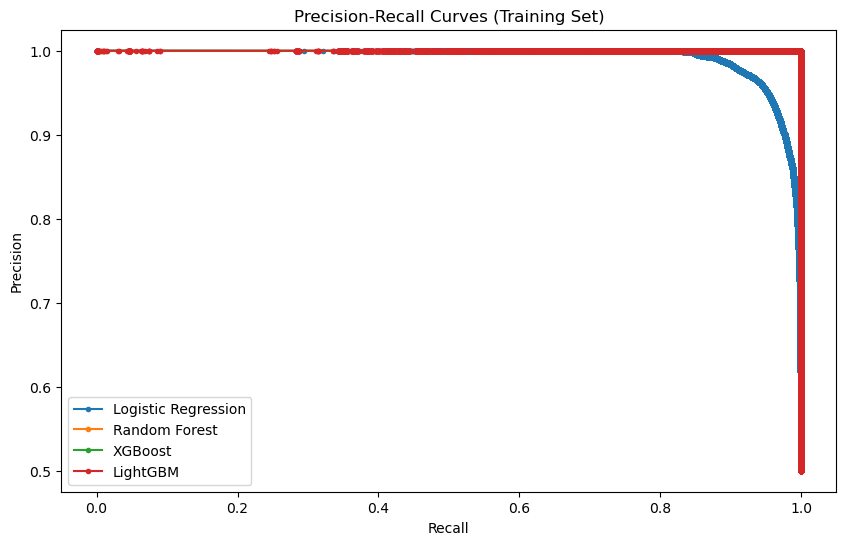

In [12]:
plt.figure(figsize=(10, 6))

# Logistic Regression
plt.plot(recall_best_lr, precision_best_lr, marker='.', label='Best Logistic Regression (AUPRC: {:.4f})'.format(auprc_best_lr))

# Random Forest
plt.plot(recall_best_rf, precision_best_rf, marker='.', label='Best Random Forest (AUPRC: {:.4f})'.format(auprc_best_rf))

# XGBoost
plt.plot(recall_best_xgb, precision_best_xgb, marker='.', label='Best XGBoost (AUPRC: {:.4f})'.format(auprc_best_xgb))

# LightGBM
plt.plot(recall_best_lgbm, precision_best_lgbm, marker='.', label='Best LightGBM (AUPRC: {:.4f})'.format(auprc_best_lgbm))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Best Models (Training Set)')
plt.legend()
plt.show()


**Evaluate the models on the testing set**

AUPRC Scores on Testing Set:
                 Model     AUPRC
0  Logistic Regression  0.676421
1        Random Forest  0.874141
2              XGBoost  0.868240
3             LightGBM  0.812239


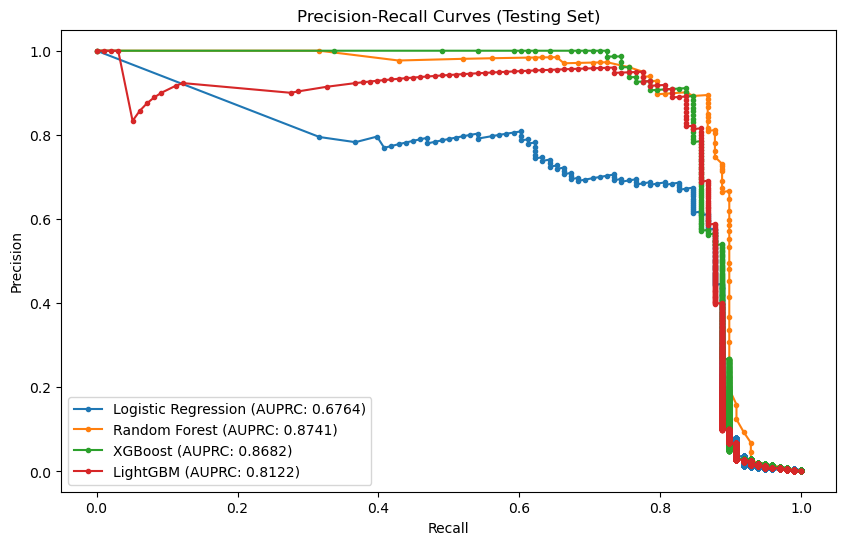

In [13]:

models = {
    'Best Logistic Regression': best_log_reg,
    'Best Random Forest': best_rf,
    'Best XGBoost': best_xgb,
    'Best LightGBM': best_lgbm
}

test_auprc = pd.DataFrame(columns=['Model', 'AUPRC'])
plt.figure(figsize=(10, 6))

for model_name, model in models.items():
    y_scores_test = model.predict_proba(X_test)[:, 1]
    
    auprc = average_precision_score(y_test, y_scores_test)
    test_auprc = test_auprc.append({'Model': model_name, 'AUPRC': auprc}, ignore_index=True)
    
    precision, recall, _ = precision_recall_curve(y_test, y_scores_test)
    
    plt.plot(recall, precision, marker='.', label=f'{model_name} (AUPRC: {auprc:.4f})')

print("AUPRC Scores on Testing Set:")
print(test_auprc)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Best Models (Testing Set)')
plt.legend()
plt.show()
